# Place Cell Analyses

Analyze TH data for place cells.

Notes:
- ToCheck: firing bins with zero firing

In [1]:
%config Completer.use_jedi = False

In [2]:
# Temp / hack - turn off warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np

from convnwb.io import load_nwbfile

from spiketools.measures.collections import detect_empty_time_ranges
from spiketools.spatial.occupancy import (compute_occupancy, compute_trial_occupancy, compute_bin_edges, 
                                          compute_bin_assignment, compute_bin_counts_pos, normalize_bin_counts)
from spiketools.spatial.utils import compute_pos_ranges, compute_bin_width
from spiketools.spatial.information import compute_spatial_information
from spiketools.spatial.place import compute_place_bins, compute_trial_place_bins
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import compute_surrogate_stats
from spiketools.plts.spatial import plot_positions, plot_heatmap, create_heat_title
from spiketools.plts.utils import make_axes
from spiketools.plts.annotate import color_pvalue
from spiketools.utils import set_random_seed
from spiketools.utils.trials import recombine_trial_data
from spiketools.utils.extract import get_range, get_values_by_time_range, get_values_by_times

In [4]:
import seaborn as sns
sns.set_context('talk')

In [5]:
import sys
sys.path.append('../code')
from utils import select_navigation
from models import create_df_place, fit_anova_place

## Settings

In [6]:
# Set random seed, for consistency shuffling
set_random_seed(101)

In [7]:
# Define the base data folder
#data_folder = '/Users/tom/Data/JacobsLab/WVTH/nwb'
data_folder = '/data12/jacobs_lab/WVTH/nwb'

In [8]:
# Define session information
session = {
    'experiment' : 'THF',
    'subject' : 'wv001',
    'session' : 0,
}

In [9]:
# Define bins to use
#bins = [7, 21]
#bins = [9, 12]
#bins = [6, 10]
bins = [5, 7]

In [10]:
# Define occupancy settings: minimum required occupancy (in seconds) & speed threshold
min_occ = 1.0
occ_setnan = True
speed_thresh = 5e-6
time_thresh = 0.25

# Collect settings for occupancy
occ_kwargs = {'minimum' : min_occ,
              'set_nan' : occ_setnan}

In [11]:
# Shuffle Settings
shuffle_approach = 'CIRCULAR'
# shuffle_approach = 'BINCIRC'
n_surrogates = 25

if shuffle_approach == 'CIRCULAR':
    shuffle_kwargs = {}
if shuffle_approach == 'BINCIRC':
    shuffle_kwargs = {'shuffle_min' : 20000}

In [12]:
# Define any quality measures
empty_time_bin = 0.25

In [13]:
# Set example unit to analyze
uind = 21

In [14]:
# Set which analysis method to run
METHOD = 'ANOVA'

## Load Data

In [15]:
# Load NWB file
nwbfile = load_nwbfile(session, data_folder)

#### Extract Time Definitions

In [16]:
# Get task time range
task_range = [0, nwbfile.trials.stop_time[-1]]

In [17]:
# Get the navigation time ranges
nav_starts = nwbfile.trials.navigation_start[:]
nav_stops = nwbfile.trials.navigation_stop[:]

#### Extract Boundaries

In [18]:
# Get boundary ranges
x_boundary = nwbfile.acquisition['boundaries']['x_range'].data[:]
z_boundary = nwbfile.acquisition['boundaries']['z_range'].data[:]

# Add a buffer to the z-range (for tower transport)
z_boundary = z_boundary + np.array([-15, 15])

In [19]:
# Collect together boundary ranges
area_range = [x_boundary, z_boundary]
print('X boundary range: ', x_boundary)
print('Z boundary range: ', z_boundary)

X boundary range:  [349.8549 419.8549]
Z boundary range:  [293.     424.3358]


#### Extract Position Data

Also, select position traces from navigation periods

In [20]:
# Get position data, selecting from navigation periods, and recombine across trials
ptimes_trials, positions_trials = select_navigation(\
    nwbfile.acquisition['position']['player_position'], nav_starts, nav_stops, False)
ptimes, positions = recombine_trial_data(ptimes_trials, positions_trials)

In [21]:
# Get speed data, selecting from navigation periods, and recombining across trials
stimes, speed = select_navigation(nwbfile.processing['position_measures']['speed'], nav_starts, nav_stops)

#### Extract Spike Data

In [22]:
# Check the number of units & keep indices
n_units = len(nwbfile.units)
keep_inds = np.where(nwbfile.units.keep[:])[0]
n_keep = len(keep_inds)
print('Number of units: {}'.format(n_units))
print('Number to keep:  {}'.format(n_keep))

Number of units: 100
Number to keep:  74


In [23]:
# Detect any empty ranges in the recording, and add them to shuffle arguments
empty_ranges = detect_empty_time_ranges(\
    [nwbfile.units.get_unit_spike_times(ii) for ii in keep_inds], empty_time_bin, task_range)
shuffle_kwargs['drop_time_range'] = empty_ranges

In [24]:
# Extract spikes for a unit of interest
spikes = nwbfile.units.get_unit_spike_times(uind)

## Position Data

In [25]:
# Compute position ranges
x_range, z_range = compute_pos_ranges(positions)

In [26]:
# Check ranges of positon
print('Position X-range:  {:1.2f} - {:1.2f} ({:1.2f})'.format(*x_range, x_range[1] - x_range[0]))
print('Position Z-range:  {:1.2f} - {:1.2f} ({:1.2f})'.format(*z_range, z_range[1] - z_range[0]))

Position X-range:  366.46 - 402.55 (36.08)
Position Z-range:  302.65 - 412.85 (110.19)


In [27]:
# Get position values for each spike
spike_positions = get_values_by_times(ptimes, positions, spikes, threshold=0.1)
#spike_positions = get_values_by_times(ptimes, positions, spikes, threshold=time_thresh)

In [28]:
# Check binning
x_bin_edges, y_bin_edges = compute_bin_edges(positions, bins, area_range)

In [29]:
# Check bin sizes
print('Bin widths: {:1.2f}, {:1.2f}'.format(compute_bin_width(x_bin_edges), compute_bin_width(y_bin_edges)))

Bin widths: 14.00, 18.76


### Occupancy

In [30]:
# Compute occupancy
occ = compute_occupancy(positions, ptimes, bins, area_range,
                        speed, speed_thresh, time_thresh, **occ_kwargs)

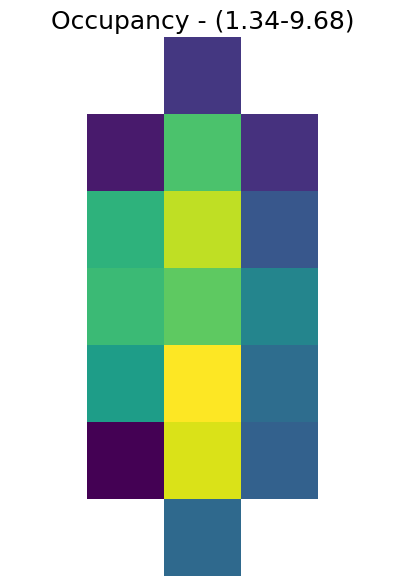

In [31]:
# Plot occupancy
plot_heatmap(occ, figsize=(5, 7), title=create_heat_title('Occupancy', occ))

## Check spike locations

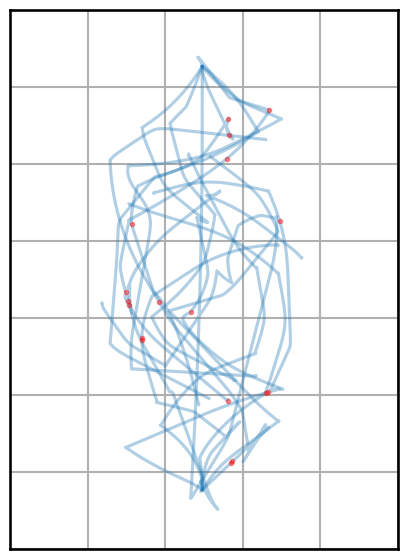

In [32]:
# Plot the map across all position traces (plotted per trial)
plot_positions(positions_trials, spike_positions,
               x_bins=x_bin_edges, y_bins=y_bin_edges,
               xlim=list(x_boundary), ylim=list(z_boundary),
               figsize=(5, 7))

## Compute Binned Spatial Firing

In [33]:
# # Compute spatial bin assignments for each spike
#x_binl, y_binl = compute_bin_assignment(spike_positions, x_bin_edges, y_bin_edges)

In [34]:
# Compute summary map of bin firing
bin_firing = compute_bin_counts_pos(spike_positions, bins, area_range)

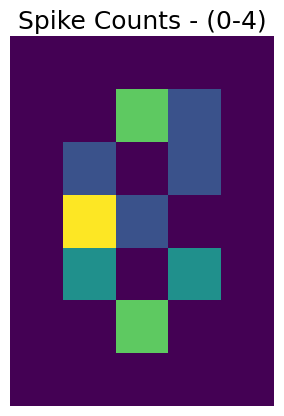

In [35]:
# Check the firing map
plot_heatmap(bin_firing, title=create_heat_title('Spike Counts', bin_firing))

In [36]:
# Normalize bin firing by occupancy
normed_bin_firing = normalize_bin_counts(bin_firing, occ)

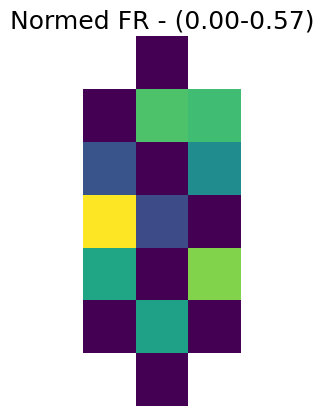

In [37]:
# Plot occupancy-normalized spatial firing
plot_heatmap(normed_bin_firing, title=create_heat_title('Normed FR', normed_bin_firing))

## Trial Level

In [38]:
# Check the number of trials
print('Number of trials: {}'.format(len(nwbfile.trials)))

Number of trials: 14


In [39]:
# Compute trial level occupancy
trial_occupancy = compute_trial_occupancy(positions, ptimes, bins, nav_starts, nav_stops,
                                          area_range, speed, speed_thresh, time_thresh, **occ_kwargs)

In [40]:
# Compute place-related firing, organized per trial
trial_place_bins_3d = compute_trial_place_bins(spikes, positions, ptimes, bins, nav_starts, nav_stops,
                                               area_range, speed, speed_thresh, time_thresh,
                                               trial_occupancy=None, flatten=False)

In [41]:
# Set a trial index to get data for
t_ind = 5

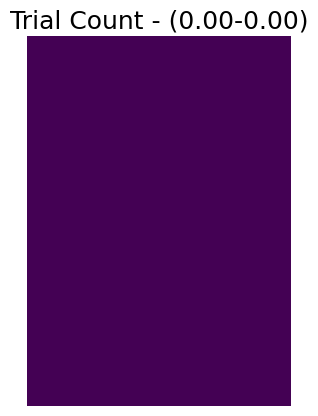

In [42]:
# Check an example trials' spatial firing
plot_heatmap(trial_place_bins_3d[t_ind, :],
             title=create_heat_title('Trial Count', trial_place_bins_3d[t_ind, :]))

## Statistical Analyses

In [43]:
# Create shuffled time series for comparison
times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates)

## Compute Spatial Information

In [44]:
# Compute the spatial information
spike_info = compute_spatial_information(normed_bin_firing, occ)
print(spike_info)

0.8981402320427198


### Shuffle Comparisons

In [45]:
# Compute spatial information measures on surrogates
surrs = np.zeros(n_surrogates)
for ind, stimes in enumerate(times_shuffle):
    bin_firing = compute_place_bins(stimes, positions, ptimes, bins, 
                                    area_range, speed, speed_thresh, time_thresh)
    surrs[ind] = compute_spatial_information(bin_firing, occ, normalize=True)

In [46]:
# Compute statistics on the surrogates
p_val, z_score = compute_surrogate_stats(spike_info, surrs, verbose=True)

p-value: 0.80
z-score: -0.92


## Compute ANOVA

In [47]:
# Collect place firing, organized per trial
trial_place_bins = compute_trial_place_bins(spikes, positions, ptimes, bins, nav_starts, nav_stops,
                                            area_range, speed, speed_thresh, time_thresh,
                                            trial_occupancy=trial_occupancy, flatten=True)

In [48]:
# Create the dataframe
df = create_df_place(trial_place_bins)

In [49]:
# Fit the ANOVA, and get the f-value
f_val = fit_anova_place(df)
f_val

1.2195925414188944

### Shuffle Comparisons

In [50]:
# Create shuffles
times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates, **shuffle_kwargs)

In [51]:
# Compute measures on surrogates
surrogates = np.zeros(n_surrogates)
for ind, shuffle in enumerate(times_shuffle):
    place_trial_shuffle = compute_trial_place_bins(\
        shuffle, positions, ptimes, bins, nav_starts, nav_stops,
        area_range, speed, speed_thresh, time_thresh,
        trial_occupancy=trial_occupancy, flatten=True)
    surrogates[ind] = fit_anova_place(create_df_place(place_trial_shuffle))

In [52]:
# Compute statistics on the surrogates
p_val, z_score = compute_surrogate_stats(f_val, surrogates, verbose=True)

p-value: 0.36
z-score: -0.20


## All Cells

In [53]:
# # Examine spatial firing across all cells
# for ii, ax in zip(keep_inds, make_axes(n_keep)):
#     spikes = nwbfile.units.get_unit_spike_times(ii)    
#     spike_positions = get_values_by_times(ptimes, positions, spikes, threshold=0.25)
#     plot_positions(positions_trials, spike_positions, title='Neuron #{}'.format(ii), 
#                    x_bins=x_bin_edges, y_bins=y_bin_edges, ax=ax)

/home1/tom.donoghue/.conda/envs/thproj/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 13, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/home1/tom.donoghue/.conda/envs/thproj/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 13, but rank is 0
  warnings.warn('covariance of constraints does not have full '


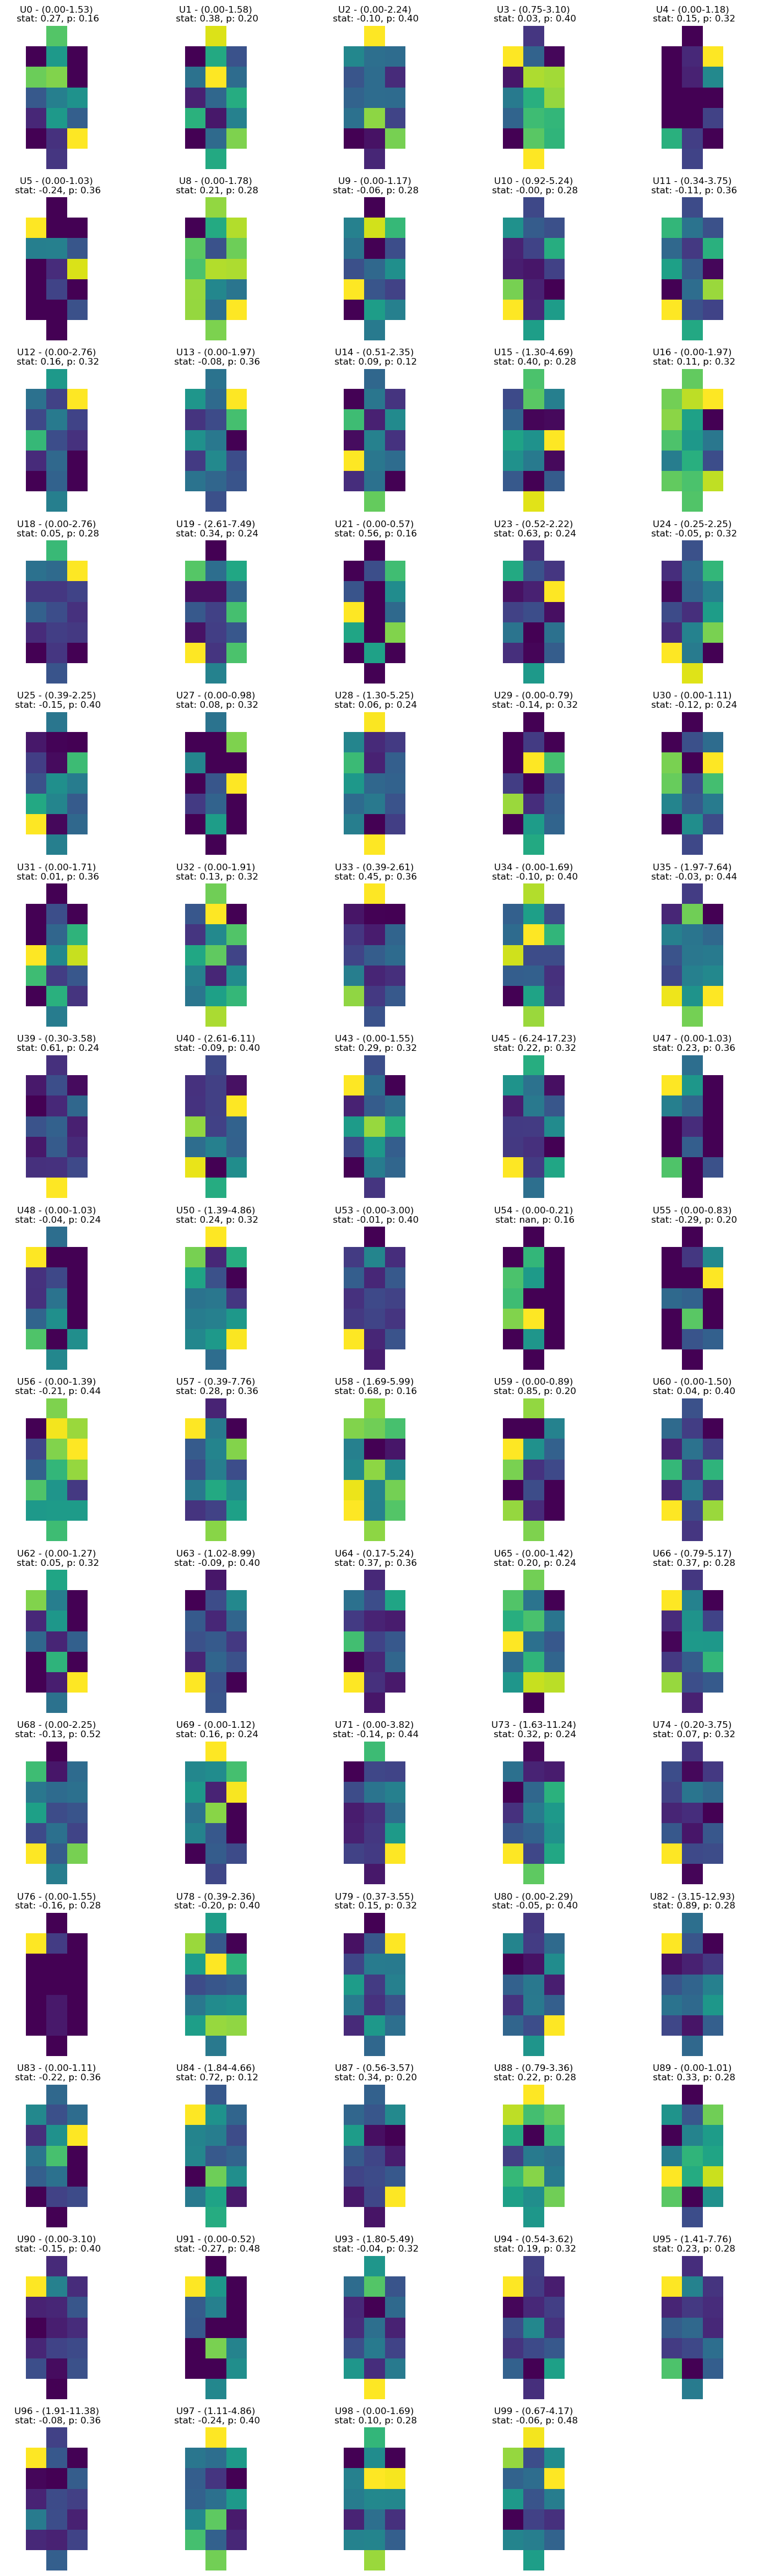

In [54]:
# Examine spatial firing across all cells
for ii, ax in zip(keep_inds, make_axes(n_keep)):

    uspikes = nwbfile.units.get_unit_spike_times(ii)

    # Compute spatially binned firing map
    bin_firing = compute_place_bins(uspikes, positions, ptimes, bins, area_range,
                                    speed, speed_thresh, time_thresh, occ)
    
    # Compute real data value
    if METHOD == 'INFO':
        data_value = compute_spatial_information(bin_firing, occ, normalize=False)

    if METHOD == 'ANOVA':
        utrial_place_bins = compute_trial_place_bins(spikes, positions, ptimes, bins, nav_starts, nav_stops,
                                                     area_range, speed, speed_thresh, time_thresh,
                                                     trial_occupancy=trial_occupancy, flatten=True)
        data_value = fit_anova_place(create_df_place(utrial_place_bins))

    surrogates = np.zeros(n_surrogates)
    times_shuffle = shuffle_spikes(uspikes, shuffle_approach, n_surrogates, **shuffle_kwargs)
    for ind, shuffle in enumerate(times_shuffle):

        if METHOD == 'INFO':            
            bf_shuffle = compute_place_bins(shuffle, positions, ptimes, bins, area_range,
                                            speed, speed_thresh, time_thresh, occ)
            surrogates[ind] = compute_spatial_information(bf_shuffle, occ, normalize=False)

        if METHOD == 'ANOVA':
            uplace_trial_shuffle = compute_trial_place_bins(\
                shuffle, positions, ptimes, bins, nav_starts, nav_stops,
                area_range, speed, speed_thresh, time_thresh,
                trial_occupancy=trial_occupancy, flatten=True)
            surrogates[ind] = fit_anova_place(create_df_place(uplace_trial_shuffle))

    # Compute z-score & p-value based on surrogates
    p_val, z_score = compute_surrogate_stats(data_value, surrogates, plot=False, ax=ax)    

    # Plot occupancy-normalized spatial firing
    plot_heatmap(bin_firing, title=create_heat_title('U{}'.format(ii), bin_firing, z_score, p_val),
                 title_color=color_pvalue(p_val), title_fontsize=12, ax=ax)